In [ ]:
import app.curve as curve
import app.calibration as c
import app.warp as w
import app.edges as e
import app.lane_finder as lf

import cv2
import matplotlib.pyplot as plt
import importlib
import numpy as np

from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
from IPython.display import HTML
%matplotlib inline

## Calibrating camera

In [ ]:
img = cv2.imread('camera_cal/calibration1.jpg')
cam_calib = c.Camera_calibrator()
cam_calib.initialize()

calibrator = c.Camera_calibrator()
calibrator.initialize()
undist = calibrator.calibrate(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')

plt.subplot(1,2,2)
plt.title('Undistorted')
plt.imshow( undist )

## Bird eye view

In [ ]:
img = cv2.imread('extra/test3.jpg')
im = np.zeros_like(img)

#img1 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# white
img2 = img.copy()
img2[:,:,0] = img2[:,:,0]*0.0
img2[:,:,2] = img2[:,:,2]*0.0
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2YCrCb)
im[:,:,0] = cv2.equalizeHist(img2[:,:,1])
im[:,:,1] = img[:,:,0]

#im[:,:,0] = img1[:,:,1]
#im[:,:,1] = img2[:,:,1]

#img[:,:,0] = img[:,:,0]*0.0
#img[:,:,2] = img[:,:,2]*0.0
#img[:,:,2] = cv2.equalizeHist(img[:,:,2])
#img[:,:,2] = img[:,:,2]*0.5

edges = e.Edges(im)
yellow = edges.gradient_color_inrange((0,0,0), (255,0,0))
#white = edges.gradient_color_inrange((0,0, 0), (0,30,0))


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
#plt.imshow(img)
plt.imshow(img[:,:,0],cmap='gray')
plt.title('Augmented')

plt.subplot(1,2,2)
plt.title('Mask')
plt.imshow(yellow, cmap='gray')

In [ ]:
img = cv2.imread('extra/test1.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
#img[:,:,1] = 0
#img[:,:,0] = 0
#res = cv2.bitwise_or(img[:,:,0], img[:,:,2])

# Yellow and white
res = img[:,:,2]
res[res == 255] = 254
res[res > 200] = 255
res[res < 255] = 0

# Yellow and white
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
res1 = cv2.equalizeHist(img2[:,:,1])
res1[res == 255] = 254
res1[res < 30] = 255
res1[res < 255] = 0

res2 = cv2.bitwise_or(res,res1)

#res[res > 210] = 255
#res[res < 255] = 0
#img[:,:,0] = cv2.equalizeHist(img[:,:,0])
#plimshow(img[:,:,0], cmap='gray')
plt.imshow(res2, cmap='gray')

In [ ]:
chan_0 = np.copy(im[:,:,0])
chan_0[chan_0 < 20] = 255
chan_0[chan_0 < 255] = 0
plt.imshow(chan_0, cmap='gray')

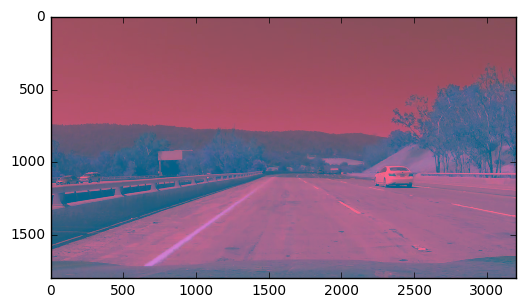

In [255]:
img = cv2.imread('extra/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
#img[:,:,0] = cv2.equalizeHist(img[:,:,0])
#img[:,:,0] = 0
#img[:,:,1] = 0
chan_2 = img[:,:,2]
chan_2 = cv2.equalizeHist(chan_2)
chan_2[chan_2>250] = 255
chan_2[chan_2<255] = 0
plt.imshow(img, cmap='gray')

In [243]:
def read_image(fname):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def equalize_color_hist(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
    result = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    return result

def detect_yellow_line(im):
    img = im.copy()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    #img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,0] = 0
    img[:,:,1] = 0
    chan_2 = img[:,:,2]
    chan_2 = cv2.equalizeHist(chan_2)
    chan_2[chan_2>253] = 255
    chan_2[chan_2<255] = 0
    return chan_2

def detect_white_yellow(im):
    img = im.copy()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # Yellow and white
    res = img[:,:,2]
    #res = cv2.equalizeHist(img[:,:,2])
    #res[res == 255] = 10
    res[res < 255] = 0
    res[res != 0] = 255
    #res[res < 240] = 0
    

    # Yellow and white
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    res1 = img2[:,:,1]
    #res1 = cv2.equalizeHist(img2[:,:,1])
    #res1 = img2[:,:,1]
    #res1[res == 255] = 254
    res1[res1 < 240] = 0
    #res1[res > 1] = 255

    res2 = cv2.bitwise_or(res,res1)
    return res1

img = read_image('extra/test1.jpg')
img = equalize_color_hist(img)

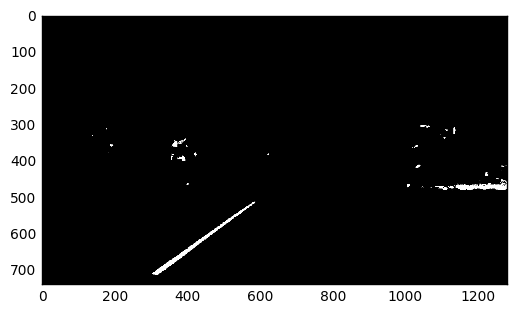

In [247]:
mask1 = detect_white_yellow(img)
mask2 = detect_yellow_line(img)
mask = cv2.bitwise_or(mask1, mask2)
plt.imshow(mask2, cmap='gray')

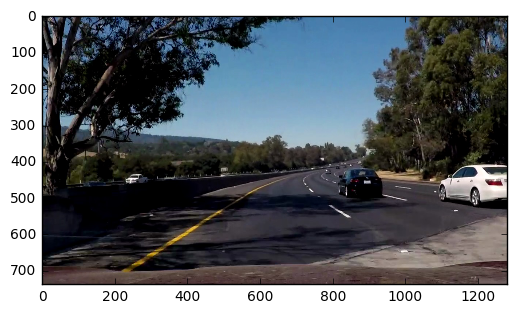

In [270]:
img = read_image('extra/test4.jpg')

plt.imshow(img)

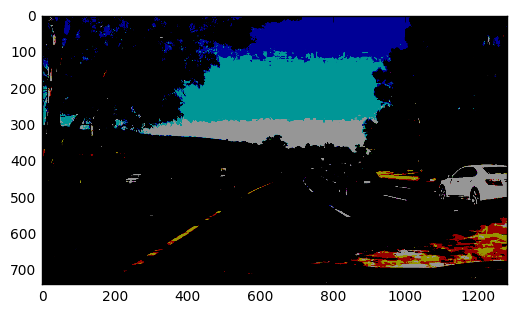

In [319]:
img = read_image('extra/test4.jpg')
#img = equalize_color_hist(img)
ret,thresh1 = cv2.threshold(img,140,150,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,100,200,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,254,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,200,255,cv2.THRESH_TOZERO_INV)
plt.imshow(thresh1)

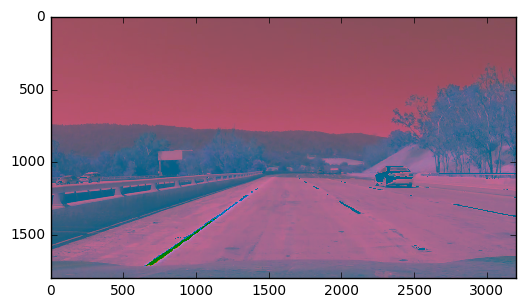

In [264]:
plt.imshow(thresh5)